<a href="https://colab.research.google.com/github/barakmam/ECG-Arrhythmia-Classification/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy.signal as sg

def checkDevice():
    if torch.cuda.is_available():
        torch.cuda.current_device()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    print("running calculations on: ", device)
    return device

# Data

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

In [30]:
!wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.1/

Streaming output truncated to the last 5000 lines.
Length: 120000 (117K) [application/octet-stream]
Saving to: ‘physionet.org/files/ptb-xl/1.0.1/records500/21000/21588_hr.dat’

physionet.org/files 100%[===================>] 117.19K  --.-KB/s    in 0s      

2021-07-13 15:38:02 (259 MB/s) - ‘physionet.org/files/ptb-xl/1.0.1/records500/21000/21588_hr.dat’ saved [120000/120000]

--2021-07-13 15:38:02--  https://physionet.org/files/ptb-xl/1.0.1/records500/21000/21588_hr.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 611 [text/plain]
Saving to: ‘physionet.org/files/ptb-xl/1.0.1/records500/21000/21588_hr.hea’

physionet.org/files 100%[===================>]     611  --.-KB/s    in 0s      

2021-07-13 15:38:03 (166 MB/s) - ‘physionet.org/files/ptb-xl/1.0.1/records500/21000/21588_hr.hea’ saved [611/611]

--2021-07-13 15:38:03--  https://physionet.org/files/ptb-xl/1.0.1/records500/21000/21589_hr.dat
Reusing existing connection to phy

In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'path/to/ptbxl/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [ ]:
!pip install wfdb
import wfdb

In [ ]:
# rec = pd.read_csv("/content/100.csv")
# annotation = pd.read_csv('/content/100annotations.txt', delimiter = " ")

In [ ]:
# plt.figure(figsize=(18, 8))
# plt.plot(np.fft.fftshift(np.arange(30000)*360/30000), 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(rec["'MLII'"][:30000])))))
# plt.ylim([0, 100000])

In [ ]:
# fileName = glob.glob("/content/physionet.org/files/mitdb/1.0.0/*.dat")
# len(fileName)

In [ ]:
# signals, fields = wfdb.rdsamp('/content/physionet.org/files/mitdb/1.0.0/100', channels=[0], sampfrom=0)
# display(signals)
# display(fields)

In [5]:
record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/100') 
annotation = wfdb.rdann("/content/physionet.org/files/mitdb/1.0.0/100", extension='atr')


In [21]:
record = wfdb.rdsamp('/content/physionet.org/files/mitdb/1.0.0/100')
annotation = wfdb.rdann('/content/physionet.org/files/mitdb/1.0.0/100', 'atr', sampto=3000)

In [ ]:
import os
wfdb.dldatabase('mitdb', os.path.join(os.getcwd, 'mitdb'))

In [8]:
annotation.sample

(2274,)

In [10]:
# !git clone https://github.com/barakmam/ECG-Arrhythmia-Classification.git

Cloning into 'ECG-Arrhythmia-Classification'...
fatal: could not read Username for 'https://github.com': No such device or address


In [22]:
record

(array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 {'base_date': None,
  'base_time': None,
  'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
  'fs': 360,
  'n_sig': 2,
  'sig_len': 650000,
  'sig_name': ['MLII', 'V5'],
  'units': ['mV', 'mV']})

In [15]:
# record.__dict__["p_signal"][0, 0]
7247*-0.02359597

-170.99999459

In [28]:
!kaggle datasets download -d shayanfazeli/heartbeat

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [10]:
sum(record.__dict__["p_signal"])

array([-199094.33499999, -124172.38000001])

In [ ]:
# 1011/record.__dict__["p_signal"][0, 1]
# a = -6862.068965517242
# b = -15553.846153846152
# np.array([a, b])*(record.__dict__["p_signal"])[:13, :]

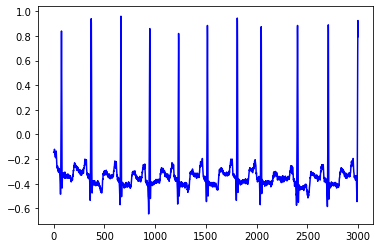

In [76]:
plt.plot(record.__dict__["p_signal"][:3000, 0],'b')
# plt.plot(record.__dict__["p_signal"][:1000, 1], 'k')

plt.show()

(0.0, 2.0)

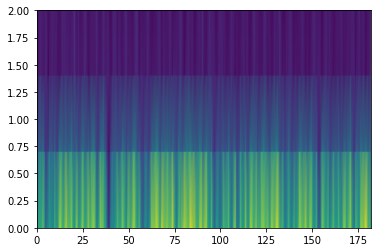

In [77]:
f, t, Zxx = sg.stft(record.__dict__["p_signal"][:2**16, 1], fs=360, nperseg=512)
# f, t, Zxx = sg.stft(rec["'MLII'"][:1024], fs=360, nperseg=512, noverlap=0)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.ylim([0, 2])
# plt.xlim([0, 100])


In [ ]:
import multiprocessing as mp
import os.path as osp
import subprocess
from glob import glob

from tqdm import tqdm

input_dir = "/content/physionet.org/files/mitdb/1.0.0/*.atr"
ecg_data = sorted([osp.splitext(i)[0] for i in glob(input_dir)])
pbar = tqdm(total=len(ecg_data))


def run(file):
    params = ["python", "dataset-generation.py", "--file", file]
    subprocess.check_call(params)
    pbar.update(1)


if __name__ == "__main__":
    p = mp.Pool(processes=mp.cpu_count())
    p.map(run, ecg_data)

# Training loop


In [ ]:
def trainNet(net, n_epochs, batch_size, learning_rate, step, patience, valCalcFreq, train_loader, val_loader, device):
    # Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("learning_rate=", learning_rate)
    print("step=", step)
    print("patience=", patience)
    print("=" * 30)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    p = 0

    # Time for printing
    training_start_time = time.time()

    # Statistics:
    numDeleted = np.array([])
    train_acc_total = []
    val_acc_total = np.array([0])
    train_loss_total = np.array([])
    val_loss_total = np.array([])

    for epoch in range(n_epochs):
        train_loss = 0
        train_hits = 0
        train_samples_checked = 0
        start_time = time.time()

        net.train()
        for batch_idx, (x, labels) in enumerate(train_loader, 0):

            # Get inputs
            x, labels = x.to(device), labels.to(device)

            # Forward pass
            preds = net(x)
            loss = criterion(preds, labels)
            
            # Set the parameter gradients to zero, backward pass, optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update statstics:
            train_loss += loss.data
            train_hits += (preds.argmax(1) == labels).sum()
            train_samples_checked += len(preds)
            
        train_loss_total.append(train_loss.data / len(train_loader))
        train_acc_total.append(train_hits/train_samples_checked)

        print("Epoch [{}/{}]:\t Took {:.2f}s.\t Train: loss = {:.3f} Acc = {:.3f}"
              .format(epoch, n_epoch, time.time() - start_time, train_loss_total[-1], train_acc_total[-1]))

        if epoch % valCalcFreq == 0:
            # At the end of the epoch, do a pass on the validation set
            val_start_time = time.time()
            val_loss = 0
            val_hits = 0
            val_samples_checked = 0
            net.eval()
            with torch.no_grad():
                for (x, labels) in val_loader:
                    x, labels = x.to(device), labels.to(device)
                    # Forward pass
                    val_preds = net(x)
                    loss = criterion(val_preds, labels)

                     # Update statstics:
                    val_loss += loss.data
                    val_hits += (val_preds.argmax(1) == labels).sum()
                    val_samples_checked += len(labels)

            val_acc_total.append(val_hits / val_samples_checked)
            val_loss_total.append(val_loss / len(val_loader))
            
            print("Epoch [{}/{}]:\t Took {:.2f}s.\t Validation: loss = {:.3f} Acc = {:.3f}"
                  .format(epoch, epoch_n, time.time() - val_start_time, val_loss_total[-1], val_acc_total[-1]))
            if epoch > 0 and val_acc_total[-1] <= val_acc_total[-2]:
                p += 1
            else:
                p = 0
            if epoch == n_epochs:
                break

    print("Training finished, took {:.3f}s".format(time.time() - training_start_time))
    return net, train_acc_total, train_loss_total, val_acc_total, val_loss_total

# References

1. Dataset: [Moody GB, Mark RG. The impact of the MIT-BIH Arrhythmia Database. IEEE Eng in Med and Biol 20(3):45-50 (May-June 2001). (PMID: 11446209)](http://ecg.mit.edu/george/publications/mitdb-embs-2001.pdf)

2. Main paper: [ECG Arrhythmia Classification Using STFT-Based Spectrogram and Convolutional Neural Network](https://ieeexplore.ieee.org/abstract/document/8759878)